<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center><font size=8>Embeddings with Word2Vec</center></font></h1>
<h1><center>Google Play Store Sentiment Analysis</center></h1>
<h3><center>Charlcye Mitchell, April 2024</center></h3>

# **LVC 3: Deep Learning Primer - The World of Neural Networks**

# **Google Play Store Sentiment Analysis**

## **Problem Statement**

This notebook is meant to give a quick demonstration of how we can create Word2Vec embeddings for any corpus of text, and use that to put together a quick solution to an NLP problem such as Sentiment Analysis.

**It's important to recognize the key role that Embeddings play in Natural Language Processing - even in the age of Generative AI (which fundamentally still rely on the same idea). Natural Language Applications are possible only when we can encode words into some kind of numerical representation, because machines only understand numbers and not text.** This is often done by projecting words into a vector space or hidden space ("hidden" because we don't know how to interpret the dimensions of this vector space), where the most important property is that **words with similar meanings have similar vectors.** **These vectors are also called the Word Embeddings for that particular word.** The major advances in Deep Learning for difficult Natural Language Processing tasks would not have been possible without this "Embedding Model" of representing words and documents.

**In this case study, we are going to predict the sentiment of the ratings of an app based upon its reviews, by encoding the text of the reviews using Word2Vec**. The sentiments of the reviews are categorized into 3 classes - good, neutral and poor.

This data set has been scraped from the Google Play Store.

## **Dataset Description**

The data contains over 12,000 reviews of different app store applications by real users. The data also contains the rating that was given by them, so it can be classified into positive, neutral or negative reviews.

- **content:** Review Text
- **score:** Rating given to the application by the user (1 - 5) where 5 & 4 are good, 3 is neutral, and 1 & 2 are poor

## **Importing the necessary libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install tqdm
from tqdm import tqdm

import numpy as np

import pandas as pd

# To visualise the graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Helps to extract the data using regular expressions
import re

# Helps to visualize the wordcloud
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

!pip install gensim
from gensim.models import Word2Vec

import nltk
from nltk.corpus import stopwords

# Used in Tokenization
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.model_selection import train_test_split

# Used to encode the categorical variables
from sklearn.preprocessing import LabelEncoder

# Importing the Random Forest model
from sklearn.ensemble import RandomForestClassifier

# Metrics to evaluate the model
from sklearn.metrics import accuracy_score,classification_report
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('punkt')


import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten,Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from sklearn.preprocessing import LabelEncoder

## **Loading the Dataset**

In [ ]:

# Loading the dataset into a dataframe
df = pd.read_csv("/content/drive/MyDrive/Prac_Data/3.2 new_reviews.csv")
df.head(5)

,content,label
0,I cannot open the app anymore,poor
1,I have been begging for a refund from this app...,poor
2,Very costly for the premium version (approx In...,poor
3,"Used to keep me organized, but all the 2020 UP...",poor
4,Dan Birthday Oct 28,poor


## **Understanding the Dataset**

In [ ]:
#Checking the info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12495 entries, 0 to 12494
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  12495 non-null  object
 1   label    12495 non-null  object
dtypes: object(2)
memory usage: 195.4+ KB


**Observations:**
- All the columns have non-null values.

In [ ]:
#Check duplicate entries
df[df['content'].duplicated()]['content']

83          Very bad
327         Not free
435             good
524            Super
583             Good
            ...     
12468    Very useful
12472      Excellent
12473        love it
12476           good
12485           good
Name: content, Length: 688, dtype: object

**Observations:**
- There are 688 duplicate rows present in the DataFrame.

Now, our main focus will be to build the Word2Vec Word Embeddings for the text data.

So, let's consider only the `content` column along with the target variable `score`.

In [ ]:
data = df.copy()

<Axes: xlabel='label', ylabel='count'>

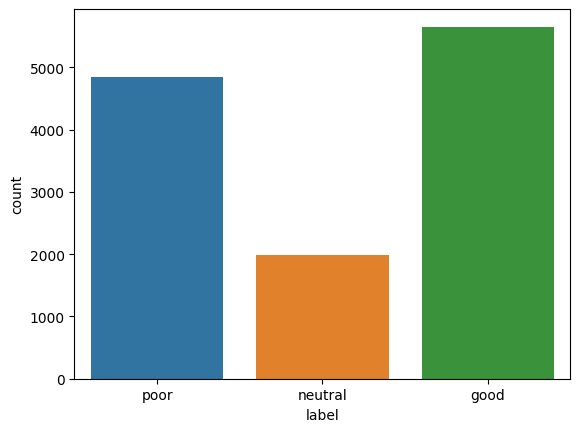

In [ ]:
# Let's view the count of each class

import seaborn as sns

sns.countplot(x=data['label'], data=data)

**Observations:**
- **There are far fewer "neutral" instances than "poor" or "good"**, which is an indicator of the polarized nature of the text data seen in online user reviews - people generally rate something either very good or very poorly in their online behavior.

There are 1858712 words in the combination of all texts.


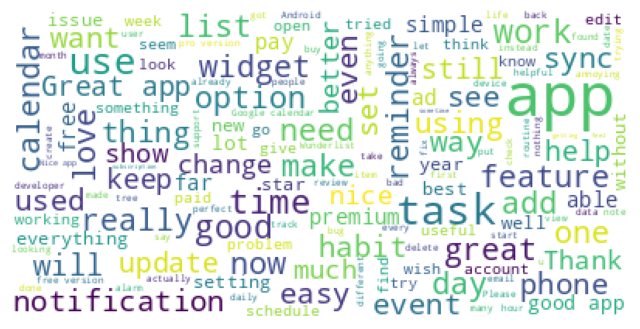

In [ ]:
# Let's look at the top 150 unique words in original feedback from the users

all_texts = " ".join(texts for texts in data.content)
print ("There are {} words in the combination of all texts.".format(len(all_texts)))

# Lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size = 40, max_words = 150, background_color="white").generate(all_texts)
plt.figure(figsize = (8,16))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

**Observation:**
- There are 1,858,712 words present in the combination of overall text.

## **Data Preprocessing**

Let's now clean the data before going on to build the Word Wmbeddings for the text.

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Regex Expressions**

A regular expression matches a broad or specific text pattern, and is strictly read left-to-right.

- '^' is a symbol that extracts characters that starts with a given pattern.

**Let's apply the expression on a single data point, and see the results:**

In [ ]:
data['content'][0:10]

0                        I cannot open the app anymore
1    I have been begging for a refund from this app...
2    Very costly for the premium version (approx In...
3    Used to keep me organized, but all the 2020 UP...
4                                  Dan Birthday Oct 28
5    It has changed how I viewed my different lists...
6    I'm only looking for a grocery list app but ev...
7    Reset my free trial, new phone I'd like to see...
8    How do to stop monthly payment because i don't...
9    I complain about not crashes and it was immedi...
Name: content, dtype: object

In [ ]:
print("Before applying the expression :", data['content'][3])
pattern = '[^a-zA-Z0-9]'
res = re.sub(pattern, ' ', data['content'][3])

print("After applying the expression :", res)

Before applying the expression : Used to keep me organized, but all the 2020 UPDATES have made a mess of things !!! Y cudn't u leave well enuf alone ??? Guess ur techies feel the need to keep making changes to justify continuing to collect their salary !!! 🤤🤤🤤
After applying the expression : Used to keep me organized  but all the 2020 UPDATES have made a mess of things     Y cudn t u leave well enuf alone     Guess ur techies feel the need to keep making changes to justify continuing to collect their salary        


We can clearly observe that we have removed the special characters and numbers from the text. Also, we observe that there are extra spaces in many places in the text - let's remove these using another regular expression.

- **\s+**: The regular expression \s is a predefined character class. It indicates a single whitespace character. The plus sign + is a greedy quantifier, which means one or more times.

In [ ]:
print("Before applying the expression :", res)
pattern = '\s+'
resf = re.sub(pattern, ' ', res)

print("After applying the expression :", resf)

Before applying the expression : Used to keep me organized  but all the 2020 UPDATES have made a mess of things     Y cudn t u leave well enuf alone     Guess ur techies feel the need to keep making changes to justify continuing to collect their salary        
After applying the expression : Used to keep me organized but all the 2020 UPDATES have made a mess of things Y cudn t u leave well enuf alone Guess ur techies feel the need to keep making changes to justify continuing to collect their salary 


- We have successfully removed the extra spaces present in the text from the previous output.

Let's remove the numbers and other numerals from the data. The range [0-9] is not always equivalent to \d. In python3, [0-9] matches only 0123456789 characters, while \d matches [0-9] and other digit characters, for example Eastern Arabic numerals ٠١٢٣٤٥٦٧٨٩.

In [ ]:

print("Before applying the expression :", resf)
pattern = '\d+'
resl = re.sub(pattern, ' ', resf)

print("After applying the expression :", resl)

Before applying the expression : Used to keep me organized but all the 2020 UPDATES have made a mess of things Y cudn t u leave well enuf alone Guess ur techies feel the need to keep making changes to justify continuing to collect their salary 
After applying the expression : Used to keep me organized but all the   UPDATES have made a mess of things Y cudn t u leave well enuf alone Guess ur techies feel the need to keep making changes to justify continuing to collect their salary 


In [ ]:
final_corpus = []

for i in range(data.shape[0]):

    # It removes the numbers, special characters, spaces

    text = re.sub('[^a-zA-Z0-9]', ' ', data['content'][i])

    # Lowering the text
    text = text.lower()

    # To remove the extra spaces in the data
    text = re.sub(r'\s+',' ',text)

    # To remove the numbers and other arabic numeric symbols
    text = re.sub(r'\d',' ',text)

    # Splitting the text
    text = text.split()

    # Removing the stopwords
    text = [word for word in text if not word in stopwords.words('english')]

    # joining the words into text
    text = ' '.join(text)

    # appending the text to the final_corpus list
    final_corpus.append(text)

data['final_text'] = final_corpus

Let's look at the top 150 unique words in the feedback where we have applied some preprocessing steps:

There are 1155388 words in the combination of all texts.


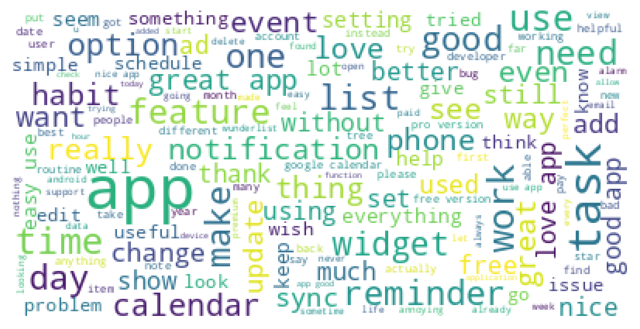

In [ ]:
all_texts1 = " ".join(texts for texts in data.final_text)
print ("There are {} words in the combination of all texts.".format(len(all_texts1)))

# Lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size = 40, max_words = 150, background_color="white").generate(all_texts1)
plt.figure(figsize = (8,16))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## **Word Embeddings**


Word Embeddings are a word representation type that represents words with a 1-Dimensional vector. The representations are such that **words with similar meanings or similar semantics will have similar vectors.** This is a Natural Language Understanding technique to map words into vectors of real numbers using various ML methods such as Neural Networks, probabilistic models, or dimensionality reduction on the word co-occurrence matrix. Some important word embedding models are Word2Vec (Google), GloVe (Stanford), and FastText (Facebook).

In this notebook, we are going to look at the Word2vec implementation of word embeddings.

## **Word2Vec**

- **Word2Vec is a group of shallow, two-layer neural networks** that are trained to represent the linguistic and contextual similarity of words through numbers based on their semantics as received from the corpus of text it is trained on.
- Word2Vec takes as its input a large corpus or document of text and produces a vector space. The choice for the dimensionality of the vector space /embedding vector is typically a few hundreds. Each unique word in the document is assigned a corresponding vector in the space.
- Word vectors are positioned in the vector space such that words that share common contexts/meaning in the corpus are located close to one another in the space. **Mathematically, the embeddings of these words will have a dot product closer to 1.**
- Embeddings learned through Word2Vec have proven to be successful on a variety of Natural Language Processing tasks.
- Word2Vec retains the semantic meaning of different words in a document. Another great advantage of the Word2Vec approach is that **the size of the embedding vector is small in comparison to the vocabulary size.**


In [ ]:
words_list =[]

for i in data['final_text']:

    li = list(i.split(" "))

    words_list.append(li)

In [ ]:
# Let's have a look into words_list
words_list[0:5]

[['cannot', 'open', 'app', 'anymore'],
 ['begging', 'refund', 'app', 'month', 'nobody', 'replying'],
 ['costly',
  'premium',
  'version',
  'approx',
  'indian',
  'rupees',
  'per',
  'year',
  'better',
  'download',
  'premium',
  'version',
  'app',
  'apkmos',
  'website',
  'use',
  'microsoft',
  'list',
  'app',
  'far',
  'better'],
 ['used',
  'keep',
  'organized',
  'updates',
  'made',
  'mess',
  'things',
  'cudn',
  'u',
  'leave',
  'well',
  'enuf',
  'alone',
  'guess',
  'ur',
  'techies',
  'feel',
  'need',
  'keep',
  'making',
  'changes',
  'justify',
  'continuing',
  'collect',
  'salary'],
 ['dan', 'birthday', 'oct']]

## **Creating the Word2Vec Word Embeddings**

Word2Vec takes the following parameters:

**Min_count**: It will ignore all the words with a total frequency lower than this.

**Workers**: These are the threads to train the model.

In [ ]:
!pip install --user gensim

In [ ]:
import gensim

In [ ]:
# Model creation
word2vec_model= Word2Vec(words_list, min_count = 1, workers = 4)

In [ ]:
word2vec_model

In [ ]:
# saving the model
word2vec_model.save("word2vec.model")

Let's have a quick look at the vocabulary words:

In [ ]:
words = word2vec_model.wv.key_to_index
len(words)

10766

**Observations:**
- Every word get mapped to an appropriate word index from the whole text present in the data.

**Let's check out a random word embedding using the trained model:**

In [ ]:
word = "problem"
word2vec_model.wv[word]

array([-0.2807448 ,  0.70687795,  0.40144944,  0.10913657,  0.00479619,
       -0.7651886 , -0.32846186,  1.298655  , -0.29729375, -0.37470642,
       -0.5584219 , -1.2074019 , -0.14931038,  0.36374813,  0.4358922 ,
       -0.44643274, -0.20626019, -0.5243426 , -0.07703685, -1.3016497 ,
        0.74321395,  0.54140866,  0.14663896,  0.06310511, -0.5664349 ,
        0.22069617, -0.44766563, -0.4064705 , -0.37147522, -0.06057758,
        0.46932518,  0.18731241,  0.05871656, -0.0651341 ,  0.1520968 ,
        0.5924577 ,  0.20033272, -0.23918977, -0.4340735 , -1.3353138 ,
       -0.31999   , -0.09884872, -0.21604666,  0.06868429,  0.34989527,
       -0.09317109, -0.7660527 , -0.06778076,  0.41209257,  0.264566  ,
       -0.25858214, -0.507057  , -0.06774803,  0.04610299, -0.4273878 ,
        0.68958765,  0.27332157, -0.01400673, -0.6351306 ,  0.10108865,
        0.5039564 ,  0.16511971,  0.13477652,  0.3256719 , -1.0200899 ,
        0.33765125,  0.45686483,  0.6545342 , -0.5900826 ,  0.67

In [ ]:
# Let's see the vocab size
print("Length of the vocab is = ", len(list(word2vec_model.wv.key_to_index)))

Length of the vocab is =  10766


In [ ]:
# Top 10 similar words to the word 'happy'

similar = word2vec_model.wv.similar_by_word('happy')
print(similar)

[('enough', 0.999311089515686), ('beautiful', 0.9990257024765015), ('functionality', 0.9989522695541382), ('expensive', 0.998537540435791), ('bad', 0.9984360933303833), ('lots', 0.9984238743782043), ('everything', 0.998098611831665), ('disappointed', 0.9973956942558289), ('year', 0.9973356127738953), ('disappointing', 0.9973019361495972)]


In [ ]:
# Top 10 similar words to the word 'premium'

similar = word2vec_model.wv.similar_by_word('premium')
print(similar)

[('paid', 0.9935691952705383), ('pro', 0.9927734732627869), ('free', 0.985578715801239), ('buy', 0.9725584983825684), ('bought', 0.9709538221359253), ('full', 0.966881513595581), ('version', 0.9646410942077637), ('costly', 0.9646142721176147), ('pay', 0.9635330438613892), ('restricted', 0.9581097364425659)]


## **Building the Random Forest Classifier**

In [ ]:
words = word2vec_model.wv.key_to_index
wvs = word2vec_model.wv[words]

In [ ]:
def average_word_vectors(words, model, vocabulary, num_features):

    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, word2vec_model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):

    vocabulary = set(word2vec_model.wv.key_to_index)

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]

    return np.array(features)




feature_size = 100

# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus = words_list, model = word2vec_model,
                                             num_features = feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.245533,0.632697,0.400682,0.204722,-0.064483,-0.763095,-0.220318,1.202329,-0.344187,-0.395075,...,0.930596,0.083822,0.100921,0.340694,1.012523,0.644049,-0.180716,-1.130930,0.134005,0.076626
1,-0.104586,0.294691,0.189927,0.116790,-0.053363,-0.388438,-0.056675,0.566929,-0.188014,-0.220794,...,0.443720,0.027031,0.031100,0.160777,0.510976,0.301624,-0.109138,-0.522437,0.064349,0.054836
2,-0.153673,0.516438,0.325507,0.191765,-0.043130,-0.548376,0.028946,0.929914,-0.186996,-0.493037,...,0.851882,-0.072721,0.006030,0.330685,0.857981,0.421766,-0.224735,-0.765728,-0.000749,0.268686
3,-0.152159,0.334838,0.221125,0.133047,-0.024444,-0.516156,-0.056857,0.739892,-0.276651,-0.266778,...,0.538959,0.061118,0.003117,0.153101,0.658890,0.388987,-0.074445,-0.657472,0.092308,-0.007988
4,-0.043231,0.101176,0.070990,0.024004,-0.002193,-0.122654,-0.043703,0.201303,-0.057402,-0.065530,...,0.165681,0.016419,0.013596,0.051699,0.165373,0.098519,-0.013796,-0.187733,0.022078,-0.000762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12490,-0.143945,0.305761,0.221063,0.130579,-0.023274,-0.528091,-0.060641,0.732262,-0.309176,-0.272830,...,0.499109,0.101315,-0.012963,0.108253,0.657748,0.387342,-0.042070,-0.659664,0.117779,-0.073022
12491,0.008760,-0.002272,-0.006867,0.007277,0.000761,0.008345,-0.002872,-0.008380,-0.004519,0.004462,...,0.008209,0.000245,-0.000154,0.008418,0.009567,-0.004852,-0.000436,-0.004150,0.001532,-0.001190
12492,-0.224851,0.573690,0.375702,0.187224,0.014768,-0.784539,-0.126335,1.177303,-0.343966,-0.474252,...,0.942807,0.061391,0.000492,0.307576,1.044673,0.624058,-0.161969,-1.050844,0.089902,0.035338
12493,-0.179907,0.479497,0.348990,0.170738,-0.028925,-0.644396,-0.097286,1.019875,-0.298279,-0.429344,...,0.839787,0.051006,-0.017055,0.254524,0.902798,0.494957,-0.130719,-0.912163,0.095934,0.039586


In [ ]:
ln = LabelEncoder()
y = ln.fit_transform(data['label'])
y

array([2, 2, 2, ..., 0, 0, 0])

In [ ]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(w2v_feature_array,y, test_size=0.2, random_state=42)

In [ ]:
# intializing the Random Forest model
model = RandomForestClassifier(random_state = 7)

# fitting the model on training set
model.fit(xtrain,ytrain)

RandomForestClassifier(random_state=7)

In [ ]:
y_pred = model.predict(xtest)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

accuracy = accuracy_score(ytest, y_pred)

# Calculate F1 score
f1 = f1_score(ytest, y_pred,average='micro')


# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)

Accuracy: 0.6350540216086434
F1 Score: 0.6350540216086434


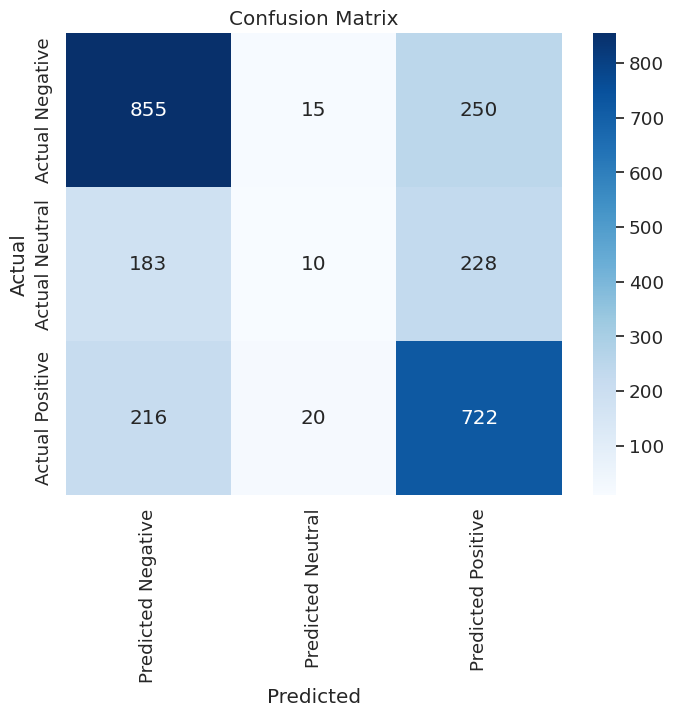

In [ ]:
confusion = confusion_matrix(ytest, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale for better readability

# Create a heatmap using Seaborn
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Neutral','Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Neutral', 'Actual Positive'])

# Add labels and a title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


## **Key Takeaways**

- As we can see above, **we're able to demonstrate a decent level of performance** on this core Sentiment Analysis task, with the Word2Vec Embeddings + ML Classifier able to get **around 63.5% on both Accuracy and F1-Score** in a **Multi-class Classification Problem**, which is often harder to solve than simpler Binary Classification Problems.